In [ ]:
# Install necessary package
!pip install tensorflow==2.12.0

In [ ]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

2.12.0
2.12.0


In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import os
from os import listdir
import cv2
import matplotlib.pyplot as plt
import imutils
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet import EfficientNetB0
from keras import layers

#from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve
import seaborn as sns

In [ ]:
!pip install imutils

In [ ]:
os.listdir('/content/drive/MyDrive/Colab Notebooks/Project Implementation/ORIGA_Data cleaning/Augmented_Train_ORIGA')

['glaucoma', 'normal']

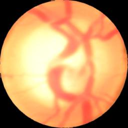

In [ ]:
#showing image of normal
im = Image.open('/content/drive/MyDrive/Colab Notebooks/Project Implementation/ORIGA_Data cleaning/Augmented_Train_ORIGA/normal/001_0_4582.jpg').resize((128, 128))
im

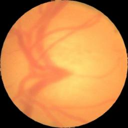

In [ ]:
#showing image of glaucoma
im = Image.open('/content/drive/MyDrive/Colab Notebooks/Project Implementation/ORIGA_Data cleaning/Augmented_Train_ORIGA/glaucoma/041_0_1990.jpg').resize((128, 128))
im

In [ ]:
#setting the directory of our data
glaucoma = os.listdir('/content/drive/MyDrive/Colab Notebooks/Project Implementation/ORIGA_Data cleaning/Augmented_Train_ORIGA/glaucoma')
normal = os.listdir('/content/drive/MyDrive/Colab Notebooks/Project Implementation/ORIGA_Data cleaning/Augmented_Train_ORIGA/normal')

#concate two data
data = np.concatenate([glaucoma,normal])
assert (len(data) == len(glaucoma)+len(normal))

#mapping our classes to 1 and 0. 1 == glaucoma and 0 == normal
target_x = np.full(len(glaucoma),1)
target_y = np.full(len(normal),0)

#label of our data
data_target = np.concatenate([target_x,target_y])

assert (len(data_target) == len(target_x)+len(target_y))
assert (len(data_target) == len(data))

print(len(target_x), len(target_y))

1008 1008


In [ ]:
#Data Prepocessing
#Setting the height and width of the image for our model
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMAGE_SIZE = [IMG_HEIGHT, IMG_WIDTH]

In [ ]:

X_data = []

# Reading images from the glaucoma directory, resizing, preprocessing, and appending to the list
for file in glaucoma:
    img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Project Implementation/ORIGA_Data cleaning/Augmented_Train_ORIGA/glaucoma/' + file)
    img2 = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    preprocessed_img = img2 # I change
    X_data.append(preprocessed_img)

# Reading images from the normal directory, resizing, preprocessing, and appending to the list
for file in normal:
    img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Project Implementation/ORIGA_Data cleaning/Augmented_Train_ORIGA/normal/' + file)
    img2 = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    preprocessed_img = img2 # I change
    X_data.append(preprocessed_img)

X_data = np.squeeze(X_data)
assert (len(X_data) == len(data) == len(data_target))


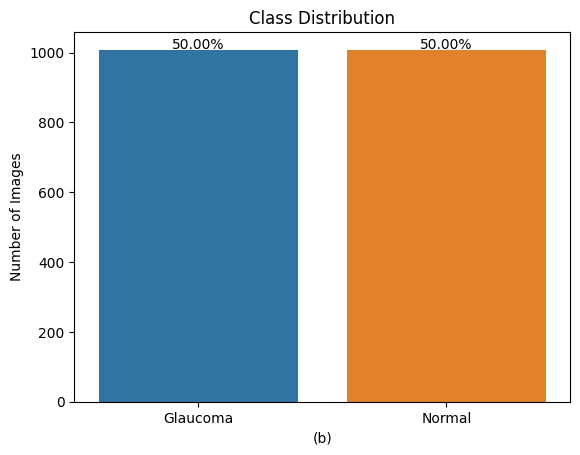

In [ ]:
import seaborn as sns

labels = []
for x in data_target:
  if x == 0:
    labels.append('Normal')
  else:
    labels.append('Glaucoma')

total = len(labels)

#sns.set(style="darkgrid")
ax = sns.countplot(x=labels)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height*100/total),
            ha="center")

plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.xlabel('(b)')
plt.show()

In [ ]:
# normalize data
X = X_data.astype('float32')
X /= 255

In [ ]:
X_data.shape

(2016, 224, 224, 3)

In [ ]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, data_target, random_state=50, test_size=0.001, stratify = data_target) #I  cahnge from 0.15 to 0.001

print(len(y_train))
print(len(y_test))

2013
3


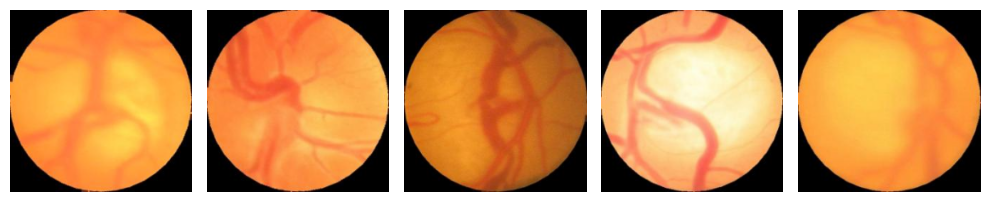

In [ ]:
#I add
#sample of training data
import matplotlib.pyplot as plt
num_samples = 5
fig, axs = plt.subplots(1, num_samples, figsize=(10, 4))

for i in range(num_samples):
    axs[i].imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))  # Assuming grayscale images
    axs[i].set_title(''.format(i))
    axs[i].axis('off')

plt.tight_layout()
plt.show()


# **EfficientNetB0**

In [ ]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from efficientnet.tfkeras import EfficientNetB0

def GetEfficientNetB0Model(INPUT_SHAPE=(224, 224, 3), bTrainConvolutionBase=False):
    conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)

    if not bTrainConvolutionBase:
        conv_base.trainable = False

    model = Sequential(name='Glaucoma_detection_With_EfficientNet_B0')
    model.add(conv_base)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    print(model.summary())
    return model


In [ ]:
model = GetEfficientNetB0Model(bTrainConvolutionBase=True)

Model: "Glaucoma_detection_With_EfficientNet_B0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________
None


In [ ]:

# Define the checkpoint filepath
checkpoint_filepath = "/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/checkpoint_ORIGA/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_ORIGA_epoch_15_batch_32_patience_6_lr=0.001_weights.best.hdf5"

# Create a ModelCheckpoint callback to save the best weights
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# Create an EarlyStopping callback to stop training when the validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

In [ ]:
#EfficientNetB0   //// The best
#patience=5 #lr=0.0001
#batch_size=32, #epochs=15, # Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=15,
    validation_split=0.18,
    callbacks=[checkpoint,
               early_stopping
               ]
)


Epoch 1/15
52/52 [==============================] - 82s 318ms/step - loss: 0.4204 - accuracy: 0.8061 - val_loss: 0.6234 - val_accuracy: 0.5840
Epoch 2/15
52/52 [==============================] - 15s 284ms/step - loss: 0.1839 - accuracy: 0.9388 - val_loss: 0.6378 - val_accuracy: 0.6171
Epoch 3/15
52/52 [==============================] - 13s 252ms/step - loss: 0.0849 - accuracy: 0.9733 - val_loss: 0.8915 - val_accuracy: 0.5702
Epoch 4/15
52/52 [==============================] - 14s 270ms/step - loss: 0.0521 - accuracy: 0.9855 - val_loss: 0.6783 - val_accuracy: 0.6639
Epoch 5/15
52/52 [==============================] - 15s 297ms/step - loss: 0.0366 - accuracy: 0.9885 - val_loss: 0.3849 - val_accuracy: 0.8154
Epoch 6/15
52/52 [==============================] - 13s 252ms/step - loss: 0.0213 - accuracy: 0.9952 - val_loss: 0.4514 - val_accuracy: 0.8154
Epoch 7/15
52/52 [==============================] - 15s 287ms/step - loss: 0.0187 - accuracy: 0.9945 - val_loss: 0.3533 - val_accuracy: 0.8512

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/Saved_model_ORIGA/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_ORIGA_epoch_15_batch_32_lr=0.0001_model.h5')

# **Model Evaluation**

In [ ]:
history = model.history.history

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']


# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/graphes_Aug_ORIGA/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_ORIGA_epoch_15_batch_32_lr=0.0001_loss_graph.png')#add
plt.show()

# Accuracy#
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/graphes_Aug_ORIGA/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_ORIGA_epoch_15_batch_32_lr=0.0001_accuracy_graph.png')
plt.show()

In [ ]:
import pickle

# Save the history
with open('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/saved_history_ORIGA/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_ORIGA_epoch_15_batch_32_lr=0.0001_history.pickle', 'wb') as file:
    pickle.dump(history, file)

# **To test the trained model on a test set**


In [ ]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
#Import libraries
import os
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout

import efficientnet.tfkeras

# Define the path to the new test dataset folder
test_data_dir = '/content/drive/MyDrive/Colab Notebooks/Project Implementation/ORIGA_Data cleaning/ORIGA_Split/Test ORIGA(Epoch_15_batch_32_lr=0.0001)'


# Load the trained model

###The bes
model = load_model('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/Saved_model_ORIGA/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_ORIGA_epoch_15_batch_32_lr=0.0001_model.h5')


# Preprocess the new test dataset
IMG_HEIGHT = 224
IMG_WIDTH = 224

X_test_new = []
y_test_new = []

for class_name in os.listdir(test_data_dir):
    class_dir = os.path.join(test_data_dir, class_name)
    if os.path.isdir(class_dir):
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
            image = image / 255.0  # Normalize pixel values to [0, 1]
            X_test_new.append(image)
            if class_name == 'glaucoma':
                y_test_new.append(1)
            else:
                y_test_new.append(0)

X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)


In [ ]:
from keras.models import load_model
# load model

#The best
model = load_model('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/Saved_model_ORIGA/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_ORIGA_epoch_15_batch_32_lr=0.0001_model.h5')

_, acc = model.evaluate(X_test_new, y_test_new)#I change here
print("Accuracy = ", (acc * 100.0), "%")

2/2 [==============================] - 6s 3s/step


<Axes: >

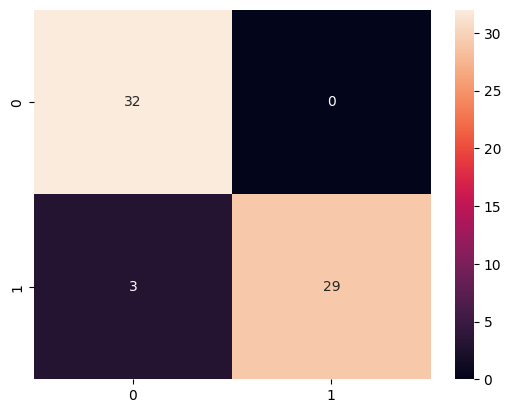

In [ ]:

#How do we know how it is doing for glaucoma vs normal?
################################################################

#Confusion matrix
#We compare labels and plot them based on correct or wrong predictions.
#Since sigmoid outputs probabilities we need to apply threshold to convert to label.

mythreshold =0.300251
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_new = (model.predict(X_test_new)>= mythreshold).astype(int)#I change here
cm=confusion_matrix(y_test_new, y_pred_new)#I change here
sns.heatmap(cm, annot=True)

#Check the confusion matrix for various thresholds. Which one is good?
#Need to balance positive, negative, false positive and false negative.

In [ ]:
#ROC can help identify the right threshold.
#Refer to video 106 for explanation of ROC curves.
##################################################################
"""
Receiver Operating Characteristic (ROC) Curve is a plot that helps us
visualize the performance of a binary classifier when the threshold is varied.
"""
#ROC
import matplotlib.pyplot as plt # I add this
from sklearn.metrics import roc_curve
y_preds = model.predict(X_test_new).ravel()#I change here to X_test_new

fpr, tpr, thresholds = roc_curve(y_test_new, y_preds)#I change here
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [ ]:

"""
#One way to find the best threshold once we calculate the true positive
and false positive rates is ...
The optimal cut off point would be where “true positive rate” is high
and the “false positive rate” is low.
Based on this logic let us find the threshold where tpr-(1-fpr) is zero (or close to 0)
"""
import pandas as pd
i = np.arange(len(tpr))
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds'])


Ideal threshold is:  2    0.174678
Name: thresholds, dtype: float32


In [ ]:

#Now use this threshold value in the confusion matrix to visualize the balance
#between tp, fp, fp, and fn


#AUC
#Area under the curve (AUC) for ROC plot can be used to understand hpw well a classifier
#is performing.
#% chance that the model can distinguish between positive and negative classes.

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

2/2 [==============================] - 4s 2s/step


<Axes: >

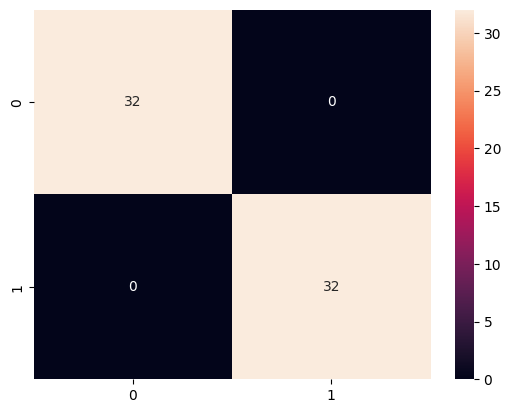

In [ ]:

#How do we know how it is doing for glaucoma vs normal?
################################################################

#Confusion matrix
#We compare labels and plot them based on correct or wrong predictions.
#Since sigmoid outputs probabilities we need to apply threshold to convert to label.

mythreshold=             0.174678
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_new = (model.predict(X_test_new)>= mythreshold).astype(int)#I change here
cm=confusion_matrix(y_test_new, y_pred_new)#I change here
sns.heatmap(cm, annot=True)

#Check the confusion matrix for various thresholds. Which one is good?
#Need to balance positive, negative, false positive and false negative.

In [ ]:
# Make predictions on the new test data
y_pred_new = model.predict(X_test_new)
y_pred_new = [1 if x >=   0.174678 else 0 for x in y_pred_new]


2/2 [==============================] - 6s 3s/step


In [ ]:
#for epoch 15 batch 32 // Test ORIGA(Epoch_15_batch_32_lr=0.0001)  //threshold  0.174685 *  /best
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Calculate performance metrics
accuracy = accuracy_score(y_test_new, y_pred_new)
precision = precision_score(y_test_new, y_pred_new)
recall = recall_score(y_test_new, y_pred_new)
f1_score = f1_score(y_test_new, y_pred_new)
auc = roc_auc_score(y_test_new, y_pred_new)
confusion_matrix = confusion_matrix(y_test_new, y_pred_new)

# Calculate specificity
specificity = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)
print("AUC:", auc)
print("Specificity:", specificity)
print("Confusion Matrix:\n", confusion_matrix)

# Generate classification report
target_names = ['normal', 'glaucoma']
classification_rep = classification_report(y_test_new, y_pred_new, target_names=target_names)

# Print the classification report
print(classification_rep)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
AUC: 1.0
Specificity: 1.0
Confusion Matrix:
 [[32  0]
 [ 0 32]]
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00        32
    glaucoma       1.00      1.00      1.00        32

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



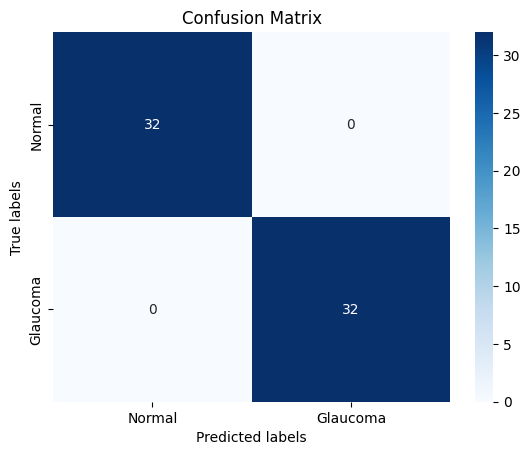

In [ ]:
#for epoch 15 batch 32 // Test ORIGA(Epoch_15_batch_32_lr=0.0001)  //threshold  0.174685 *  /best
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test_new, y_pred_new)

# Plot the confusion matrix
labels = ["Normal", "Glaucoma"]
sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# Save the figure
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/good_graph_Aug_ORIGA/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_ORIGA_epoch_15_batch_32_lr=0.0001_confusion_matrix.png")

# Show the figure
plt.show()


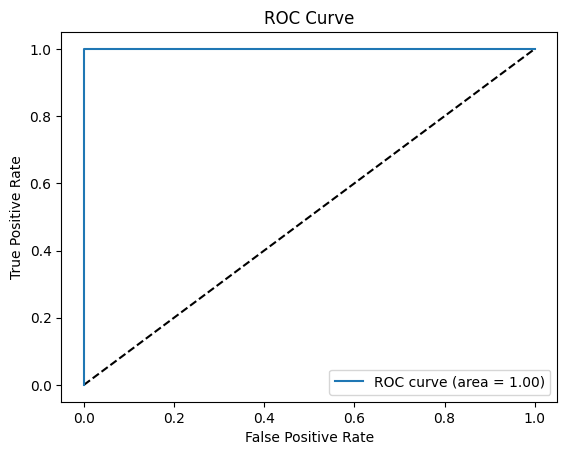

In [ ]:
#for epoch 15 batch 32 // Test ORIGA(Epoch_15_batch_32_lr=0.0001)  //threshold  0.174685 *  //////best

#ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_new, y_pred_new)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr, tpr, label='EfficientNetB0')
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/good_graph_Aug_ORIGA/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_ORIGA_epoch_15_batch_32_lr=0.0001_ROC Curve_graph.png')
plt.show();

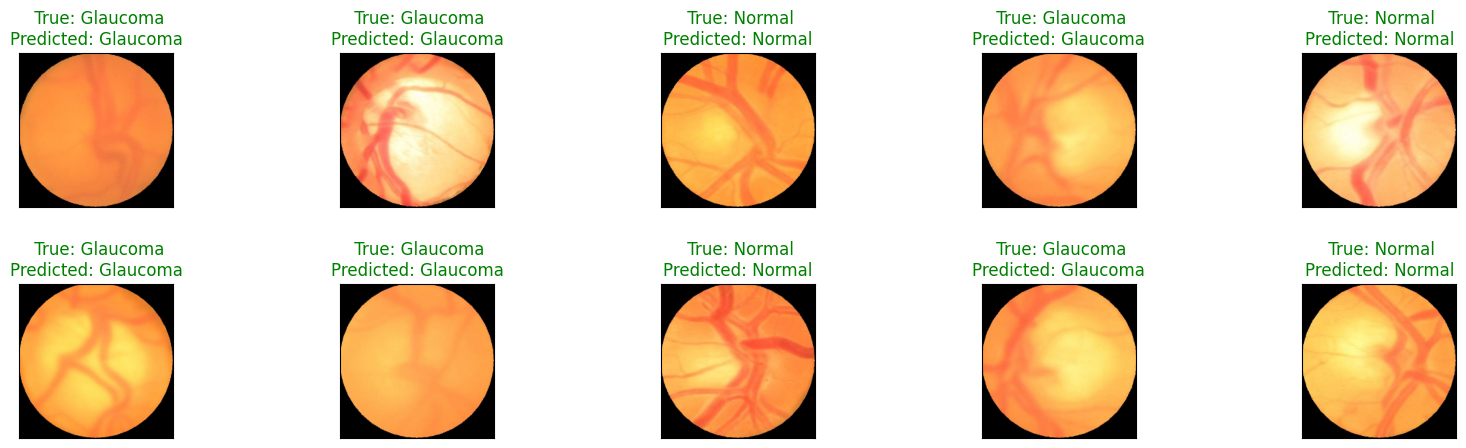

In [ ]:
#for epoch 15 batch 32 // Test ORIGA(Epoch_15_batch_32_lr=0.0001)  //threshold  0.174685 *  //////best
import cv2
import matplotlib.pyplot as plt
import numpy as np

labels = ["Normal", "Glaucoma"]

figure = plt.figure(figsize=(20, 8))

for i, index in enumerate(np.random.choice(X_test_new.shape[0], size=10, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Read the image in BGR format
    bgr_image = np.squeeze(X_test_new[index])
    # Convert the image to 8-bit (values between 0 and 255)
    bgr_image_8bit = cv2.normalize(bgr_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # Convert the 8-bit BGR image to RGB
    rgb_image = cv2.cvtColor(bgr_image_8bit, cv2.COLOR_BGR2RGB)
    # Display the RGB image
    ax.imshow(rgb_image)
    predict_index = y_pred_new[index]
    true_index = y_test_new[index]
    # Set the title for each image
    true_label = labels[true_index]
    predict_label = labels[predict_index]
    title = " True: {}\nPredicted: {}".format(true_label, predict_label)
    ax.set_title(title, color=("green" if predict_index == true_index else "red"))

# Adjust the spacing between the subplots
figure.subplots_adjust(hspace=0.5)

# Save the figure
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/good_graph_Aug_ORIGA/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_ORIGA_epoch_15_batch_32_lr=0.0001_test_sample_images.png')

In [ ]:
#To test model on test set

import cv2
import numpy as np
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt

#I add this
import efficientnet.tfkeras

# Load the segmentation model
segmentation_model = load_model('/content/drive/MyDrive/Colab Notebooks/Project Implementation/New_Experiments/Saved_model/Segmentation_UNET_Resnet34_ORIGA&RIMONEDL_with_Aug_V2_2040_without_denoising_Epoch_50_batch_16.hdf5', compile=False)

# Load the classification model
classification_model = load_model('/content/drive/MyDrive/Colab Notebooks/Project Implementation/Classification/Saved_model_ORIGA/After_use_all_augmented_for_Train/Classification_EfficientNetB0_Aug_Train_ORIGA_epoch_15_batch_32_lr=0.0001_model.h5')
# Define the preprocessing function for the segmentation model
def preprocess_segmentation_image(image):
    # Apply resize
    new_width = 128
    new_height = 128
    dim = (new_width, new_height)
    resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    # Preprocess the image
    preprocessed_image = resized_image / 255.
    return preprocessed_image

# Define the preprocessing function for the classification model
def preprocess_classification_image(image):
    # Resize the image
    img = cv2.resize(image, (224, 224))
    # Normalize the image
    img = img.astype('float32') / 255
    # Reshape the image to match the model's input shape
    img = np.expand_dims(img, axis=0)
    return img

# Load the image
image = cv2.imread('/test_ORIGA.jpg')

# Preprocess the image for segmentation
preprocessed_image = preprocess_segmentation_image(image)

# Make segmentation prediction
segmentation_prediction = segmentation_model.predict(np.expand_dims(preprocessed_image, axis=0))
segmentation_mask = np.argmax(segmentation_prediction, axis=3)[0]

# Resize the mask to match the image size
segmentation_mask_resized = cv2.resize(segmentation_mask.astype(np.uint8), (image.shape[1], image.shape[0]))


# Apply the mask to the original image
segmented_image = cv2.bitwise_and(image, image, mask=segmentation_mask_resized)

# Convert the segmented image to grayscale
gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

# Find contours in the grayscale image
contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the bounding rectangle for each contour
bounding_rectangles = [cv2.boundingRect(contour) for contour in contours]

# Get the x, y, w, h of the bounding rectangle with the maximum area
x, y, w, h = max(bounding_rectangles, key=lambda rect: rect[2] * rect[3])

# Crop the black area from the segmented image
cropped_segmented_image = segmented_image[y:y+h, x:x+w]

# Preprocess the cropped segmented image for classification
preprocessed_segmented_image = preprocess_classification_image(cropped_segmented_image)

# Make classification prediction
classification_prediction = classification_model.predict(preprocessed_segmented_image)
label = "Glaucoma" if classification_prediction[0][0] >= 0.174685 else "Normal" # rather than 0.5

# Display the images and prediction using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Input')
axs[0].axis('off')
axs[1].imshow(cv2.cvtColor(cropped_segmented_image, cv2.COLOR_BGR2RGB))
axs[1].set_title('ROI')
axs[1].axis('off')
plt.show()

print(f"The prediction for the image is: {label}")
